# T3: OLS vs IRLS for isosbestic regression (motion correction)

This notebook focuses on the motion-correction regression step used in fibre 
photometry preprocessing.

We will:
- fit **ordinary least squares (OLS)** and **robust iteratively reweighted 
    least squares (IRLS)** regressions;
- interpret the fitted parameters (slope/intercept) and goodness-of-fit;
- visualise **IRLS weights** in both signal-space and time;
- compare the corrected traces; and
- assess sensitivity to the **tuning constant**.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

from fibphot.analysis.irls import (
    SweepSpec,
    irls_tuning_sweep,
    plot_irls_tuning_sweep,
)
from fibphot.io import read_doric
from fibphot.plotting import set_plot_defaults
from fibphot.stages import (
    DoubleExpBaseline,
    HampelFilter,
    IsosbesticRegression,
    LowPassFilter,
)

set_plot_defaults()

%config InlineBackend.figure_format = "retina"

## 1) load a single session and preprocess up to baseline subtraction

To make the regression focus on motion-related covariance (rather than slow 
photobleaching drift), we first apply a standard early preprocessing:

1. Hampel (spike/outlier correction)
2. Low-pass (remove high-frequency noise)
3. Double exponential baseline fit and subtraction (photobleaching detrend)

After this, the `gcamp` and `iso` channels are *detrended*; regression then 
estimates the motion component shared between them.

In [2]:
path: str = ""  # TODO: set path to a Doric .doric file

state0 = read_doric(path)

state_pre = state0.pipe(
    HampelFilter(window_size=13),
    LowPassFilter(critical_frequency=10.0),
    DoubleExpBaseline(subtract=True),
)

state_pre.summary

(StageRecord(stage_id='0001_hampel_filter', name='hampel_filter', params={'window_size': 13, 'n_sigmas': 3.0, 'channels': 'all', 'mad_scale': 1.4826, 'mode': 'reflect', 'match_edges': True}, metrics={}, notes=None),
 StageRecord(stage_id='0002_low_pass_filter', name='low_pass_filter', params={'critical_frequency': 10.0, 'order': 2, 'sampling_rate': None, 'channels': 'all', 'representation': 'sos'}, metrics={}, notes=None),
 StageRecord(stage_id='0003_double_exp_baseline', name='double_exp_baseline', params={'subtract': True, 'channels': 'all', 'decimate_to_hz': None, 'maxfev': 2000, 'tau_fast_bounds': (60.0, 600.0), 'tau_slow_bounds': (600.0, 36000.0)}, metrics={'mean_r2': 0.9794979905882621, 'mean_rmse': 0.001003343135334578, 'decimate_factor': 1.0}, notes="Fitted double exponential baseline; parameters are stored per channel. Baseline curves are available in derived['double_exp_baseline']."))

## 2) what the regression algorithms are doing

Let:
- $x(t)$ be the **isosbestic** control trace (motion proxy),
- $y(t)$ be the **signal** trace (e.g. GCaMP / dLight).

We fit a line:
$$
y(t) \approx \alpha + \beta x(t)
$$
and interpret:
$$
\hat y(t) = \alpha + \beta x(t) \quad \text{(estimated motion component)}
$$
The motion-corrected residual is:
$$
\Delta F(t)=y(t)-\hat y(t).
$$

### OLS

OLS chooses $(\alpha,\beta)$ to minimise $\sum_t r(t)^2$, where 
$r(t)=y(t)-\alpha-\beta x(t)$. This makes it sensitive to large residuals.

### IRLS (robust regression)

IRLS is a practical way to fit *robust* linear regressions. Instead of 
minimising squared residuals (OLS), it minimises a robust loss that reduces the 
influence of outliers on the fitted line.

We still fit the same *model*:
$$
y(t) \approx \alpha + \beta x(t),
\qquad r(t)=y(t)-\alpha-\beta x(t),
$$
but we repeatedly refit it with weights.

At iteration $k$, solve a **weighted least squares** problem:
$$
(\alpha_k,\beta_k)
=\arg\min_{\alpha,\beta}\sum_t w_k(t)\,r_k(t)^2.
$$

Then recompute the weights from the residuals, and repeat.


#### Algorithm (high level)
Given paired data $\{(x(t),y(t))\}_{t=1}^n$:

1) **Initialise (OLS)**
- Fit ordinary least squares to get $(\alpha_0,\beta_0)$.

2) **Repeat for** $k=1,\dots,K$ **(until convergence):**
- **Predict**:
$$
\hat y_{k-1}(t)=\alpha_{k-1}+\beta_{k-1}x(t)
$$
- **Residuals**:
$$
r_{k-1}(t)=y(t)-\hat y_{k-1}(t)
$$

- **Estimate robust scale** (how “wide” residuals are):
  - Compute a robust $\hat\sigma$ using MAD:
$$
\hat\sigma = 1.4826 \cdot \mathrm{median}_t\left(|r_{k-1}(t)-\mathrm{median}(r_{k-1})|\right)
$$
  - If $\hat\sigma$ is tiny (almost zero), stop (nothing to reweight).

- **Standardise residuals**:
$$
u(t)=\frac{r_{k-1}(t)}{c\,\hat\sigma}
$$
where $c$ is the **tuning constant** (larger $c$ = less aggressive downweighting).

- **Compute weights** $w_k(t)$ from $u(t)$ using a chosen robust rule:

  **Huber weights**
$$
w(u)=
\begin{cases}
1, & |u|\le 1\\[3pt]
\frac{1}{|u|}, & |u|> 1
\end{cases}
$$
  Interpretation: “mostly OLS”, but outliers get reduced influence.

  **Tukey (bisquare) weights**
$$
w(u)=
\begin{cases}
(1-u^2)^2, & |u|< 1\\[3pt]
0, & |u|\ge 1
\end{cases}
$$
  Interpretation: strong robustness; extreme outliers can be effectively ignored.

- **Refit weighted least squares**
  Solve:
$$
(\alpha_k,\beta_k)
=\arg\min_{\alpha,\beta}\sum_t w_k(t)\big(y(t)-\alpha-\beta x(t)\big)^2.
$$

- **Check convergence**
  Stop if the parameter change is small, e.g.
$$
\frac{\|\theta_k-\theta_{k-1}\|}{\|\theta_{k-1}\|+\epsilon} < \mathrm{tol}.
$$

3) **Return**
- final $(\alpha,\beta)$,
- fitted line $\hat y(t)$,
- residuals $r(t)$,
- and optionally the final weights $w(t)$.

## 3) fit OLS and IRLS on the same preprocessed snapshot

We apply the regression stage twice (once with OLS and once with IRLS) starting from the same `state_pre`.
We store weights for IRLS so we can interpret what was downweighted.


In [3]:
def last_stage_id(state, stage_name: str) -> str:
    """Get the last stage ID for a given stage name."""

    return next(
        rec.stage_id
        for rec in reversed(state.summary)
        if rec.name.lower() == stage_name.lower()
    )


state_ols = IsosbesticRegression(
    control="iso",
    channels=["gcamp"],
    method="ols",
    store_weights=False,
)(state_pre)

state_irls = IsosbesticRegression(
    control="iso",
    channels=["gcamp"],
    method="irls_tukey",
    tuning_constant=1.4,
    store_weights=True,
)(state_pre)

sid_ols = last_stage_id(state_ols, "isosbestic_regression")
sid_irls = last_stage_id(state_irls, "isosbestic_regression")

fit_ols_res = state_ols.results[sid_ols]["channels"]["gcamp"]
fit_irls_res = state_irls.results[sid_irls]["channels"]["gcamp"]

fit_ols_res, fit_irls_res

({'control': 'iso',
  'intercept': 4.4068527005985217e-13,
  'slope': 1.4682146060064256,
  'r2': 0.22320509304059277,
  'method': 'ols',
  'n_iter': None,
  'max_iter': None,
  'tuning_constant': None,
  'scale': None,
  'weights': None},
 {'control': 'iso',
  'intercept': -9.647398157205875e-05,
  'slope': 1.3793953301946438,
  'r2': 0.2183501072883327,
  'method': 'irls_tukey',
  'n_iter': 78,
  'max_iter': 100,
  'tuning_constant': 1.4,
  'scale': 0.0013004123340592273,
  'weights': array([0.71585231, 0.73859695, 0.69433266, ..., 0.49547384, 0.87486567,
         0.88479238], shape=(261969,))})

## 4) regression space: isosbestic vs signal

A common diagnostic is to look at the scatter of $x$ vs $y$, and overlay the 
fitted line.

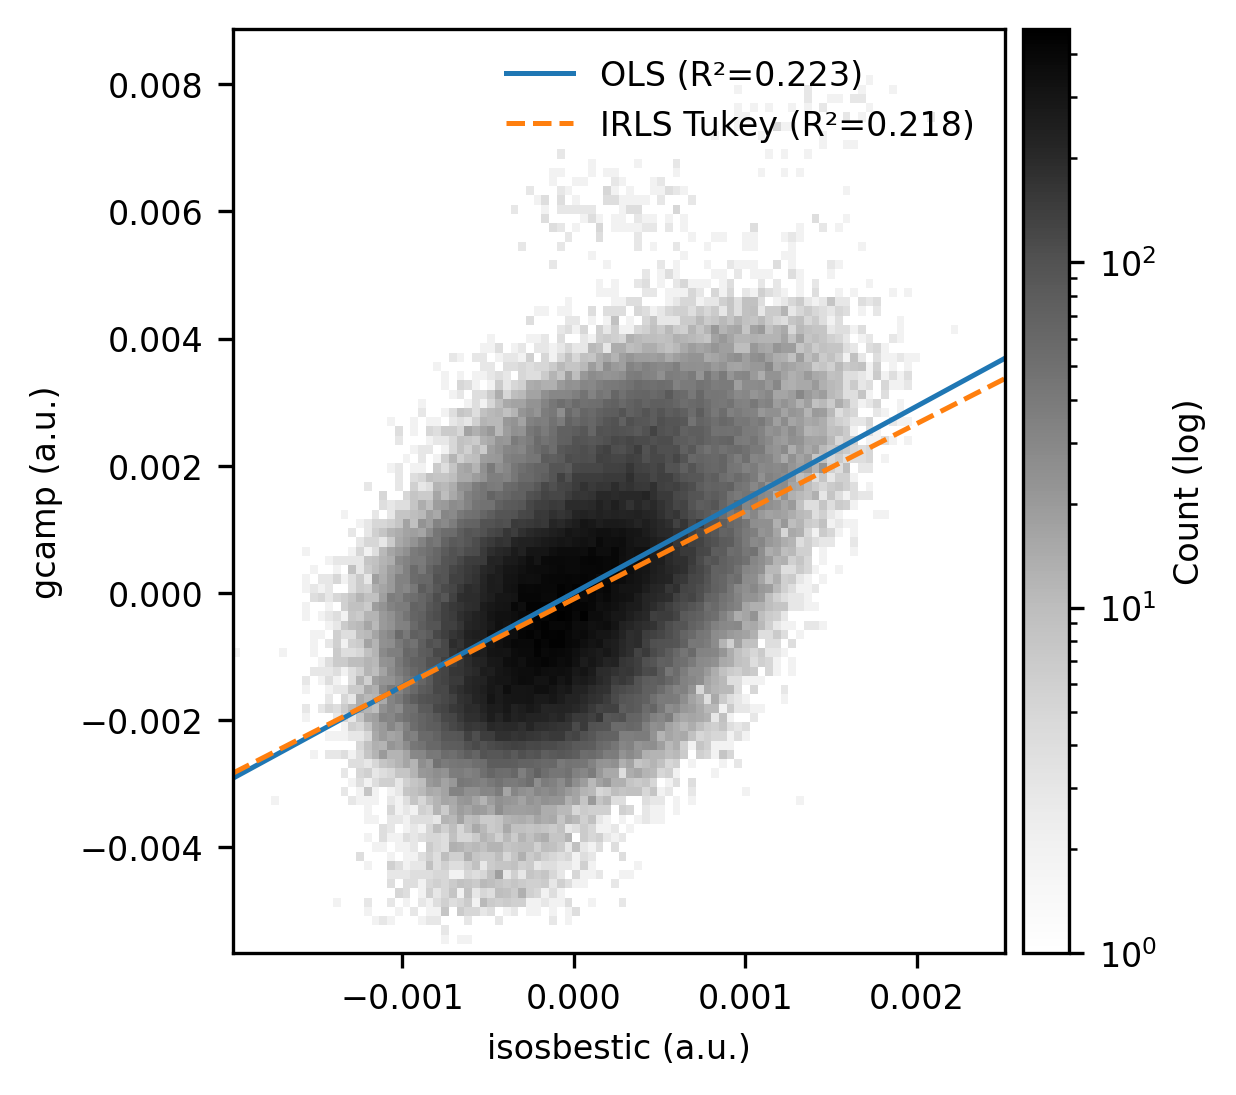

In [4]:
x = state_pre.channel("iso")
y = state_pre.channel("gcamp")

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

mask = np.isfinite(x) & np.isfinite(y)
xx = np.asarray(x)[mask]
yy = np.asarray(y)[mask]

h = ax.hist2d(xx, yy, bins=100, norm=LogNorm(), cmap="Greys")

cb = fig.colorbar(h[3], ax=ax, pad=0.02)
cb.set_label("Count (log)")

x_line = np.array([np.nanmin(x[mask]), np.nanmax(x[mask])])

ax.plot(
    x_line,
    fit_ols_res["intercept"] + fit_ols_res["slope"] * x_line,
    linewidth=1.2,
    label=f"OLS (R²={fit_ols_res['r2']:.3f})",
)

ax.plot(
    x_line,
    fit_irls_res["intercept"] + fit_irls_res["slope"] * x_line,
    linewidth=1.2,
    linestyle="--",
    label=f"IRLS Tukey (R²={fit_irls_res['r2']:.3f})",
)

ax.set_xlabel("isosbestic (a.u.)")
ax.set_ylabel("gcamp (a.u.)")
ax.legend(frameon=False)

plt.show()

## 5) IRLS weights on the scatter (what got downweighted?)

With IRLS, each time point ends up with a final weight $w(t)$. Points with low 
weight contributed very little to the fitted line.

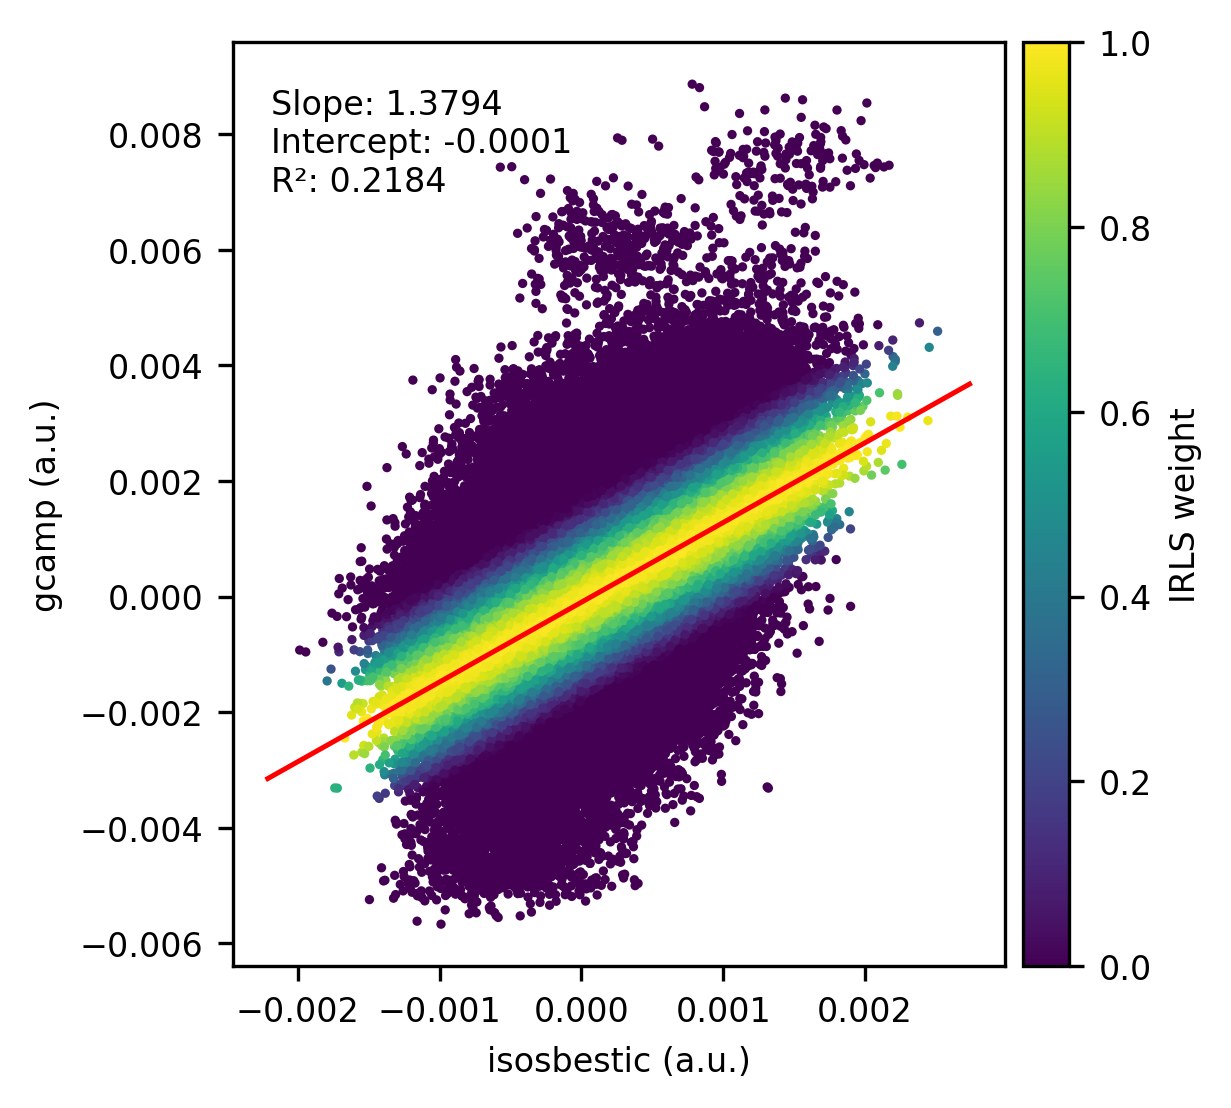

In [5]:
w = np.asarray(fit_irls_res.get("weights"), dtype=float)

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(w)
sc = ax.scatter(
    x[mask],
    y[mask],
    c=w[mask],
    s=5,
    linewidth=0.0,
)

x_line = np.array(ax.get_xlim())
ax.plot(
    x_line,
    fit_irls_res["intercept"] + fit_irls_res["slope"] * x_line,
    color="red",
    linewidth=1.2,
)

ax.text(
    0.05,
    0.95,
    (
        f"Slope: {fit_irls_res['slope']:.4f}\n"
        f"Intercept: {fit_irls_res['intercept']:.4f}\n"
        f"R²: {fit_irls_res['r2']:.4f}"
    ),
    transform=ax.transAxes,
    va="top",
    fontsize=8,
)

ax.set_xlabel("isosbestic (a.u.)")
ax.set_ylabel("gcamp (a.u.)")

cb = fig.colorbar(sc, ax=ax, pad=0.02)
cb.set_label("IRLS weight")

plt.show()

## 6) weights over time (where did IRLS downweight?)

Plotting weights over time makes it easier to see *when* the robust method decided
points were “outliers” relative to the fitted motion relationship.


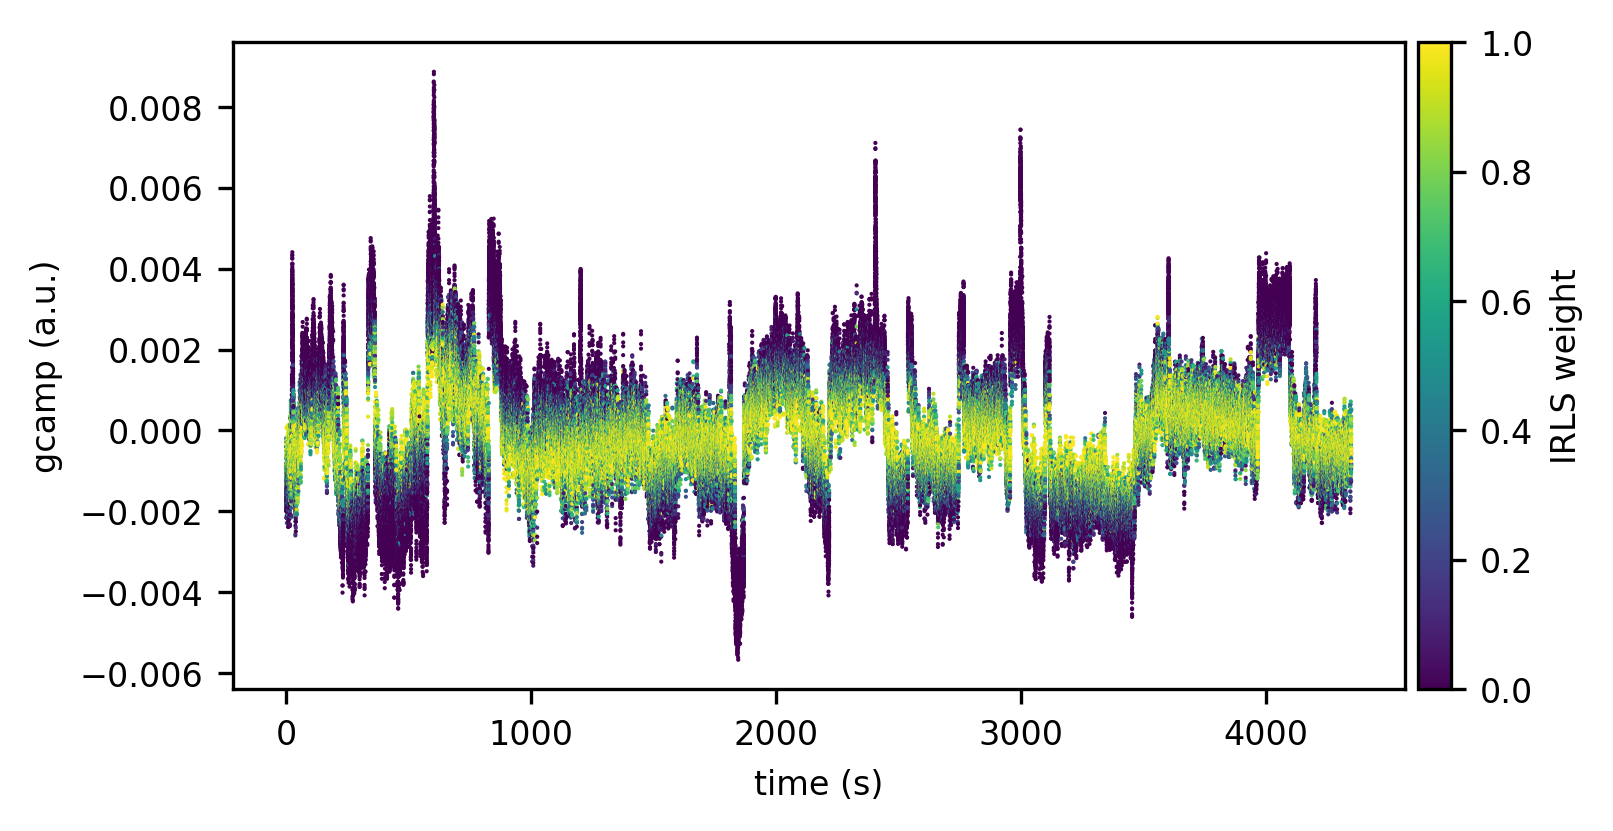

In [6]:
t = state_pre.time_seconds

fig, ax = plt.subplots(figsize=(6, 2.8), dpi=150)

mask = np.isfinite(t) & np.isfinite(y) & np.isfinite(w)
sc = ax.scatter(t[mask], y[mask], c=w[mask], s=1, linewidth=0.0)

ax.set_xlabel("time (s)")
ax.set_ylabel("gcamp (a.u.)")

cb = fig.colorbar(sc, ax=ax, pad=0.01)
cb.set_label("IRLS weight")

plt.show()

## 7) motion estimate and corrected trace in time domain

From the stage output, `derived["motion_fit"]` stores $\hat y(t)$ per channel.
This lets you visualise the raw signal, the estimated motion component, and the 
residual $\Delta F(t)$.


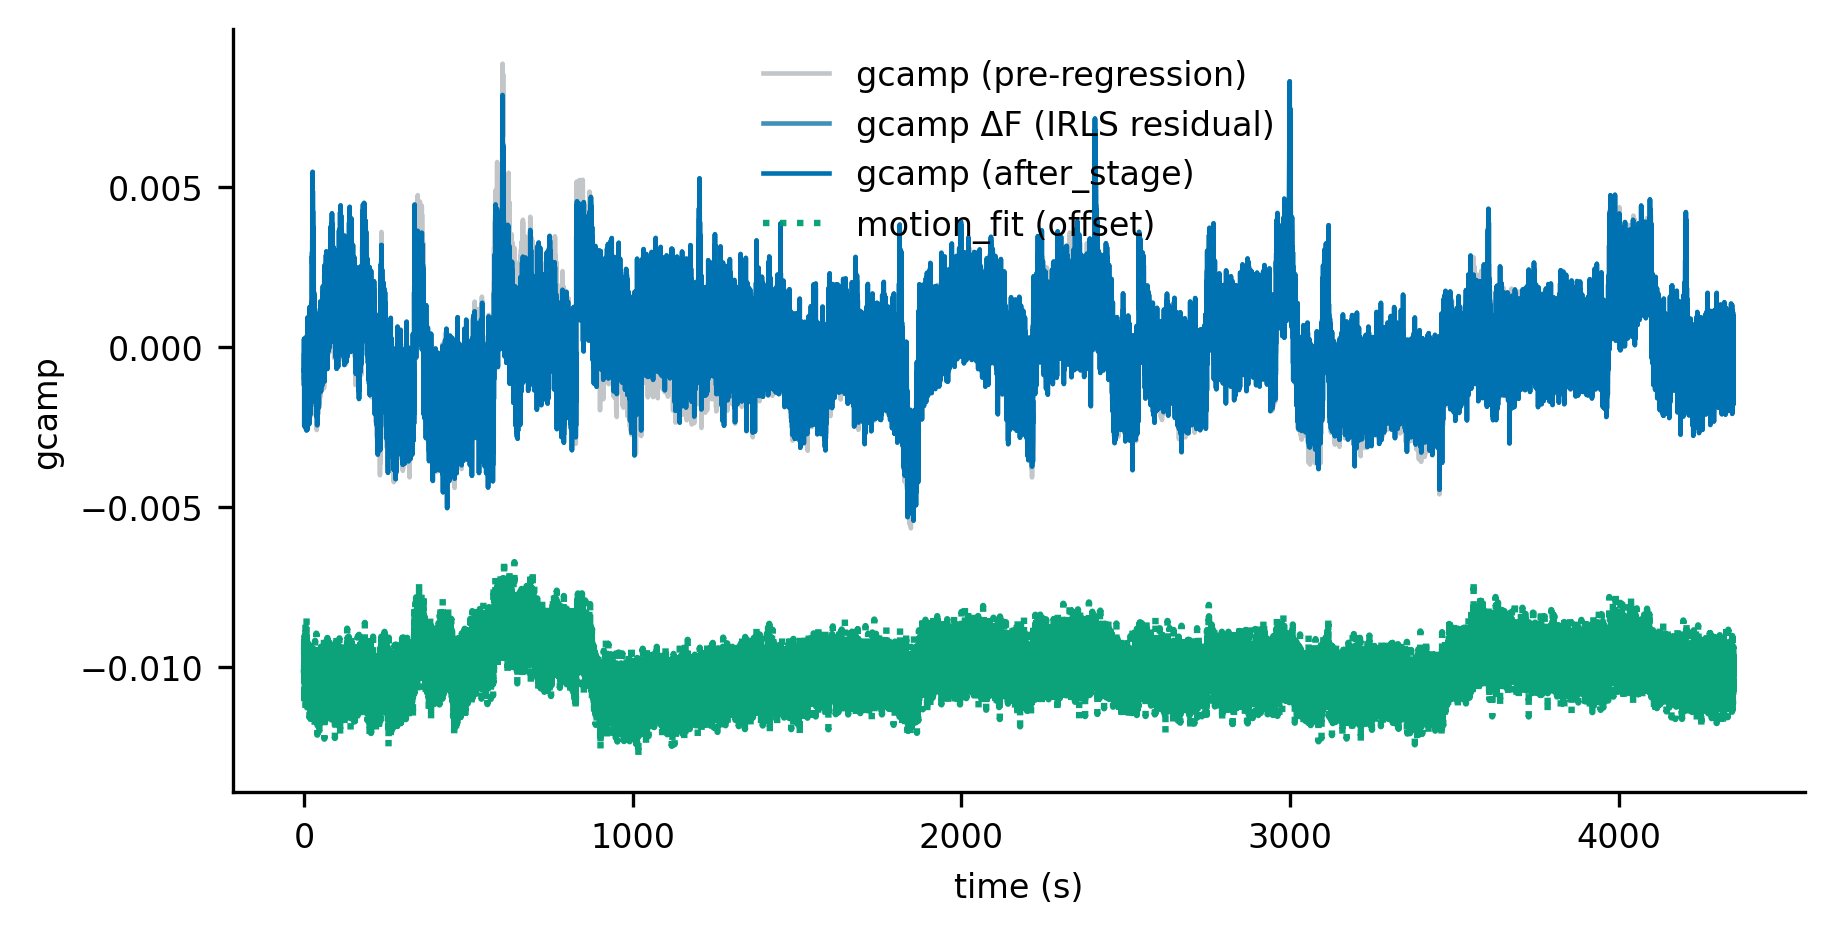

In [7]:
# motion fit for gcamp (ŷ(t))
motion_fit = state_irls.derived["motion_fit"][state_irls.idx("gcamp")]

fig, ax = state_irls.plot(
    signal="gcamp",
    view="before_stage",
    stage_name="isosbestic_regression",
    label="gcamp (pre-regression)",
    colour="#9aa0a6",
    alpha=0.6,
)

state_irls.plot(
    signal="gcamp",
    view="after_stage",
    stage_name="isosbestic_regression",
    label="gcamp ΔF (IRLS residual)",
    colour="#4091B7",
    alpha=1.0,
    ax=ax,
    show_legend=False,
)

state_irls.plot(
    signal="gcamp",
    view="after_stage",
    stage_name="isosbestic_regression",
    motion_fit_key="motion_fit",
    overlay_offset={"motion_fit": -0.01},
    ax=ax,
)

ax.legend(frameon=False, fontsize=8)
plt.show()

## 8) compare corrected residuals (OLS vs IRLS)

Both methods produce $\Delta F(t)=y(t)-\hat y(t)$.  
The main difference is *what the fitted line is allowed to chase*:

- OLS is pulled towards large residual events.
- IRLS tends to preserve large events by downweighting them in the fit.


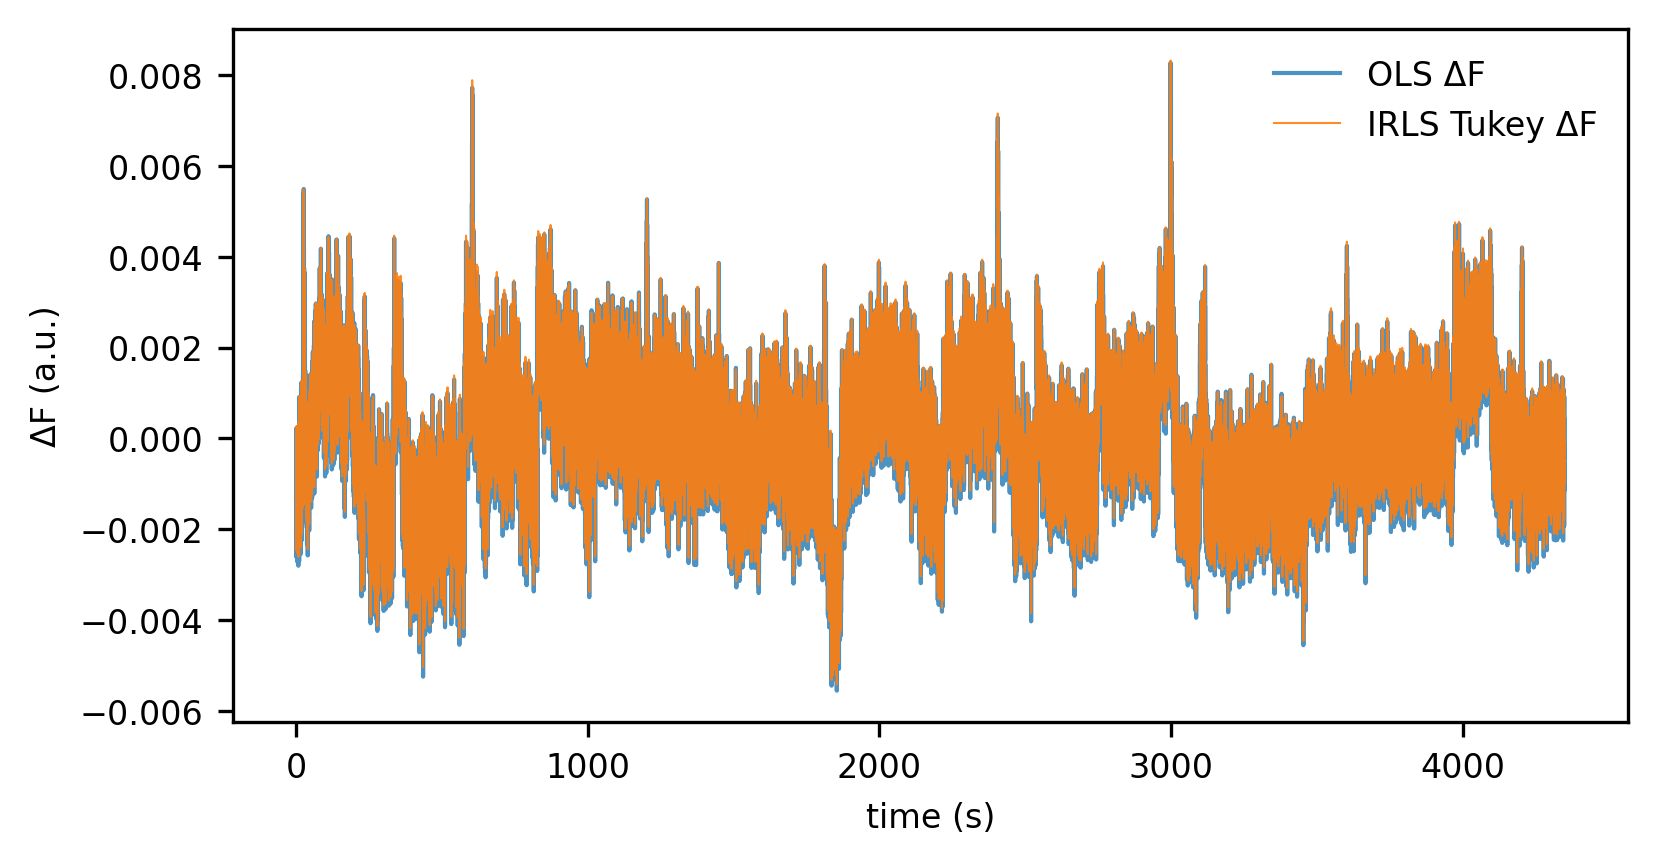

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)

ax.plot(
    state_ols.time_seconds,
    state_ols.channel("gcamp"),
    label="OLS ΔF",
    alpha=0.8,
    linewidth=1.0,
)
ax.plot(
    state_irls.time_seconds,
    state_irls.channel("gcamp"),
    label="IRLS Tukey ΔF",
    alpha=0.9,
    linewidth=0.5,
)

ax.set_xlabel("time (s)")
ax.set_ylabel("ΔF (a.u.)")
ax.legend(frameon=False)

plt.show()

## 9) Tukey vs Huber (robustness style)

- **Tukey bisquare** can *fully reject* extreme outliers (weight → 0).
- **Huber** keeps all points but downweights outliers (weight decreases ~$1/|u|$).


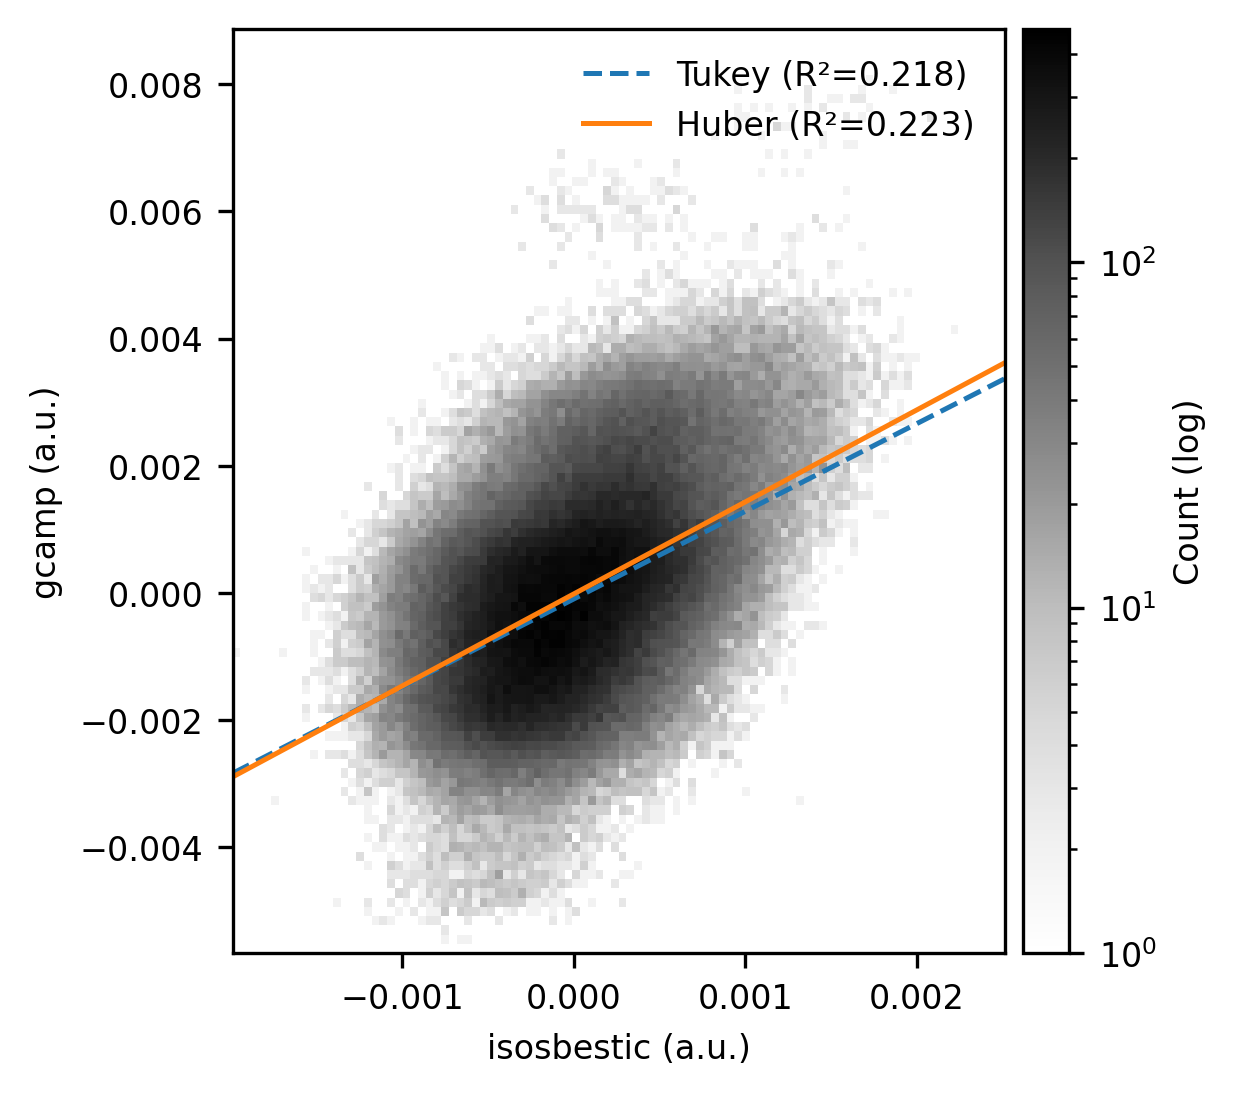

In [9]:
state_huber = IsosbesticRegression(
    control="iso",
    channels=["gcamp"],
    method="irls_huber",
    tuning_constant=1.4,
    store_weights=True,
)(state_pre)

sid_huber = last_stage_id(state_huber, "isosbestic_regression")
fit_huber = state_huber.results[sid_huber]["channels"]["gcamp"]

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

mask = np.isfinite(x) & np.isfinite(y)
xx = np.asarray(x)[mask]
yy = np.asarray(y)[mask]

h = ax.hist2d(xx, yy, bins=100, norm=LogNorm(), cmap="Greys")

cb = fig.colorbar(h[3], ax=ax, pad=0.02)
cb.set_label("Count (log)")

x_line = np.array([np.nanmin(x[mask]), np.nanmax(x[mask])])

ax.plot(
    x_line,
    fit_irls_res["intercept"] + fit_irls_res["slope"] * x_line,
    linewidth=1.2,
    linestyle="--",
    label=f"Tukey (R²={fit_irls_res['r2']:.3f})",
)

ax.plot(
    x_line,
    fit_huber["intercept"] + fit_huber["slope"] * x_line,
    linewidth=1.2,
    label=f"Huber (R²={fit_huber['r2']:.3f})",
)

ax.set_xlabel("isosbestic (a.u.)")
ax.set_ylabel("gcamp (a.u.)")
ax.legend(frameon=False)

plt.show()

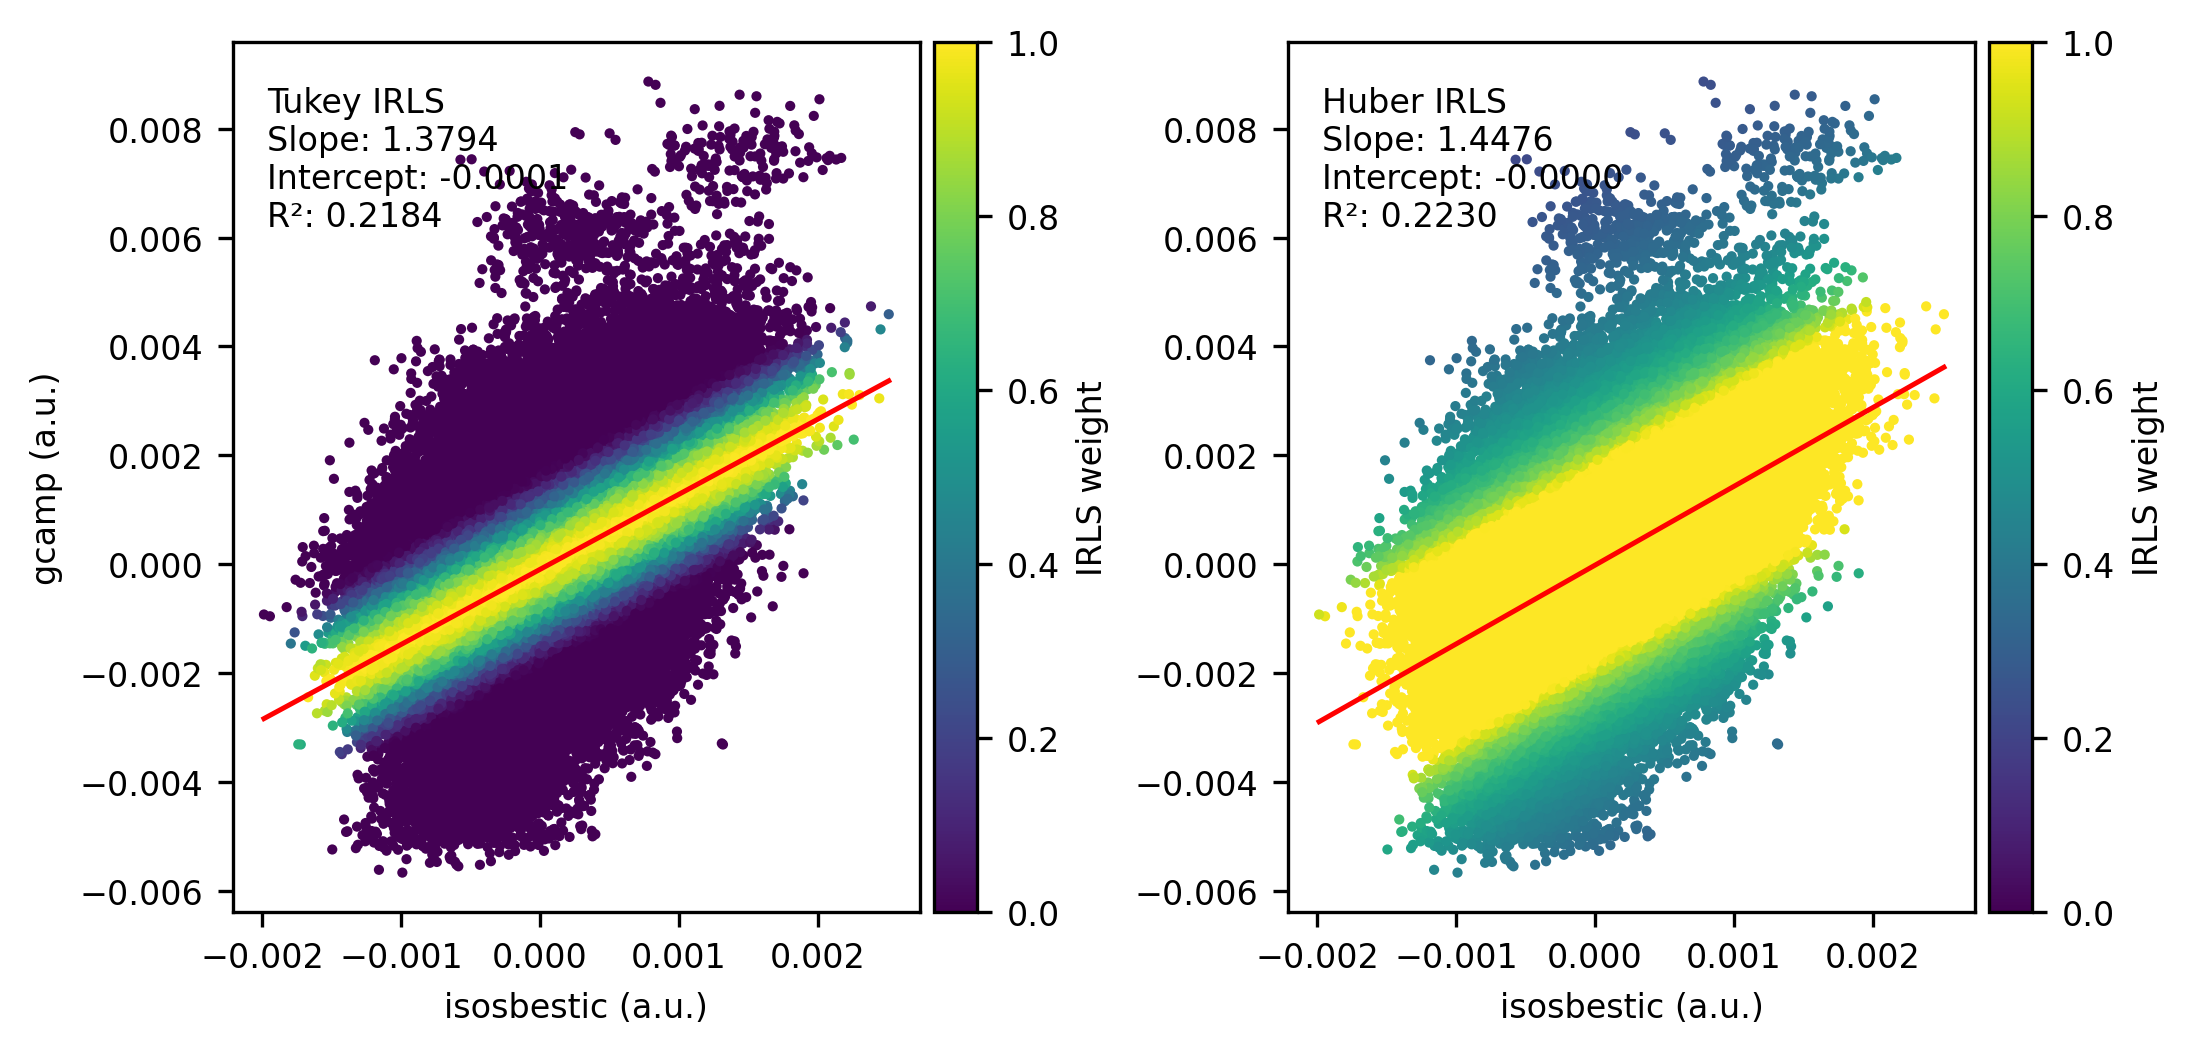

In [10]:
w_tukey = np.asarray(fit_irls_res.get("weights"), dtype=float)
w_huber = np.asarray(fit_huber.get("weights"), dtype=float)

mask_t = np.isfinite(x) & np.isfinite(y) & np.isfinite(w_tukey)
mask_h = np.isfinite(x) & np.isfinite(y) & np.isfinite(w_huber)

fig, (ax0, ax1) = plt.subplots(
    ncols=2,
    figsize=(7.2, 3.4),
    dpi=150,
    constrained_layout=True,
)

# ---- Tukey panel ----
sc0 = ax0.scatter(
    x[mask_t],
    y[mask_t],
    c=w_tukey[mask_t],
    s=6,
    linewidth=0.0,
)
x_line0 = np.array([np.nanmin(x[mask_t]), np.nanmax(x[mask_t])])
ax0.plot(
    x_line0,
    fit_irls_res["intercept"] + fit_irls_res["slope"] * x_line0,
    linewidth=1.2,
    color="red",
)

ax0.text(
    0.05,
    0.95,
    (
        "Tukey IRLS\n"
        f"Slope: {fit_irls_res['slope']:.4f}\n"
        f"Intercept: {fit_irls_res['intercept']:.4f}\n"
        f"R²: {fit_irls_res['r2']:.4f}"
    ),
    transform=ax0.transAxes,
    va="top",
    fontsize=8,
)

ax0.set_xlabel("isosbestic (a.u.)", fontsize=8)
ax0.set_ylabel("gcamp (a.u.)", fontsize=8)
ax0.tick_params(labelsize=8)

cb0 = fig.colorbar(sc0, ax=ax0, pad=0.02)
cb0.set_label("IRLS weight", fontsize=8)
cb0.ax.tick_params(labelsize=8)

# ---- Huber panel ----
sc1 = ax1.scatter(
    x[mask_h],
    y[mask_h],
    c=w_huber[mask_h],
    s=6,
    linewidth=0.0,
)
x_line1 = np.array([np.nanmin(x[mask_h]), np.nanmax(x[mask_h])])
ax1.plot(
    x_line1,
    fit_huber["intercept"] + fit_huber["slope"] * x_line1,
    linewidth=1.2,
    color="red",
)

ax1.text(
    0.05,
    0.95,
    (
        "Huber IRLS\n"
        f"Slope: {fit_huber['slope']:.4f}\n"
        f"Intercept: {fit_huber['intercept']:.4f}\n"
        f"R²: {fit_huber['r2']:.4f}"
    ),
    transform=ax1.transAxes,
    va="top",
    fontsize=8,
)

ax1.set_xlabel("isosbestic (a.u.)", fontsize=8)
ax1.set_ylabel("", fontsize=8)
ax1.tick_params(labelsize=8)

cb1 = fig.colorbar(sc1, ax=ax1, pad=0.02)
cb1.set_label("IRLS weight", fontsize=8)
cb1.ax.tick_params(labelsize=8)

vmin, vmax = 0.0, 1.0
sc0.set_clim(vmin, vmax)
sc1.set_clim(vmin, vmax)
cb0.update_normal(sc0)
cb1.update_normal(sc1)

plt.show()

## 10) sensitivity to the tuning constant

The tuning constant $c$ controls the “outlier cut-off” in standardised residual units.
Sweeping it helps you check whether your default (e.g. 1.4) lies in a stable region.

We plot:
- slope and intercept (with a twin axis, so each is readable),
- R² and iteration count (if available).


In [11]:
tcs = np.linspace(0.5, 6.0, 30)

df = irls_tuning_sweep(
    state_pre,
    tuning_constants=tcs,
    loss="tukey",
    spec=SweepSpec(control="iso", channel="gcamp", view="current"),
)

df.head(10)

,tuning_constant,slope,intercept,r2,n_iter,scale,w_mean,w_median,w_min,w_p01,w_p05,w_zero_frac,w_lt_01_frac,loss,control,channel,view,stage_name
0,0.500000,1.335165,-0.000070,0.219218,100.0,0.001302,0.209025,0.000000,0.0,0.0,0.000000,0.617317,0.678981,tukey,iso,gcamp,current,
1,0.689655,1.346962,-0.000083,0.218682,100.0,0.001301,0.283824,0.001991,0.0,0.0,0.000000,0.490188,0.568357,tukey,iso,gcamp,current,
2,0.879310,1.359606,-0.000092,0.218319,100.0,0.001301,0.354680,0.169474,0.0,0.0,0.000000,0.379324,0.466670,tukey,iso,gcamp,current,
3,1.068966,1.371661,-0.000096,0.218222,100.0,0.001301,0.421018,0.362792,0.0,0.0,0.000000,0.285721,0.376655,tukey,iso,gcamp,current,
4,1.258621,1.376912,-0.000097,0.218222,89.0,0.001301,0.482015,0.508611,0.0,0.0,0.000000,0.211670,0.298440,tukey,iso,gcamp,current,
5,1.448276,1.380080,-0.000096,0.218415,74.0,0.001300,0.537277,0.613584,0.0,0.0,0.000000,0.153281,0.233718,tukey,iso,gcamp,current,
6,1.637931,1.382587,-0.000092,0.218785,61.0,0.001301,0.587000,0.689937,0.0,0.0,0.000000,0.107856,0.180647,tukey,iso,gcamp,current,
7,1.827586,1.387048,-0.000086,0.219318,51.0,0.001301,0.631475,0.746400,0.0,0.0,0.000000,0.074314,0.136539,tukey,iso,gcamp,current,
8,2.017241,1.393727,-0.000079,0.219935,43.0,0.001301,0.670798,0.789033,0.0,0.0,0.000006,0.049788,0.101516,tukey,iso,gcamp,current,
9,2.206897,1.401031,-0.000071,0.220550,38.0,0.001301,0.705633,0.822060,0.0,0.0,0.028078,0.033164,0.074490,tukey,iso,gcamp,current,


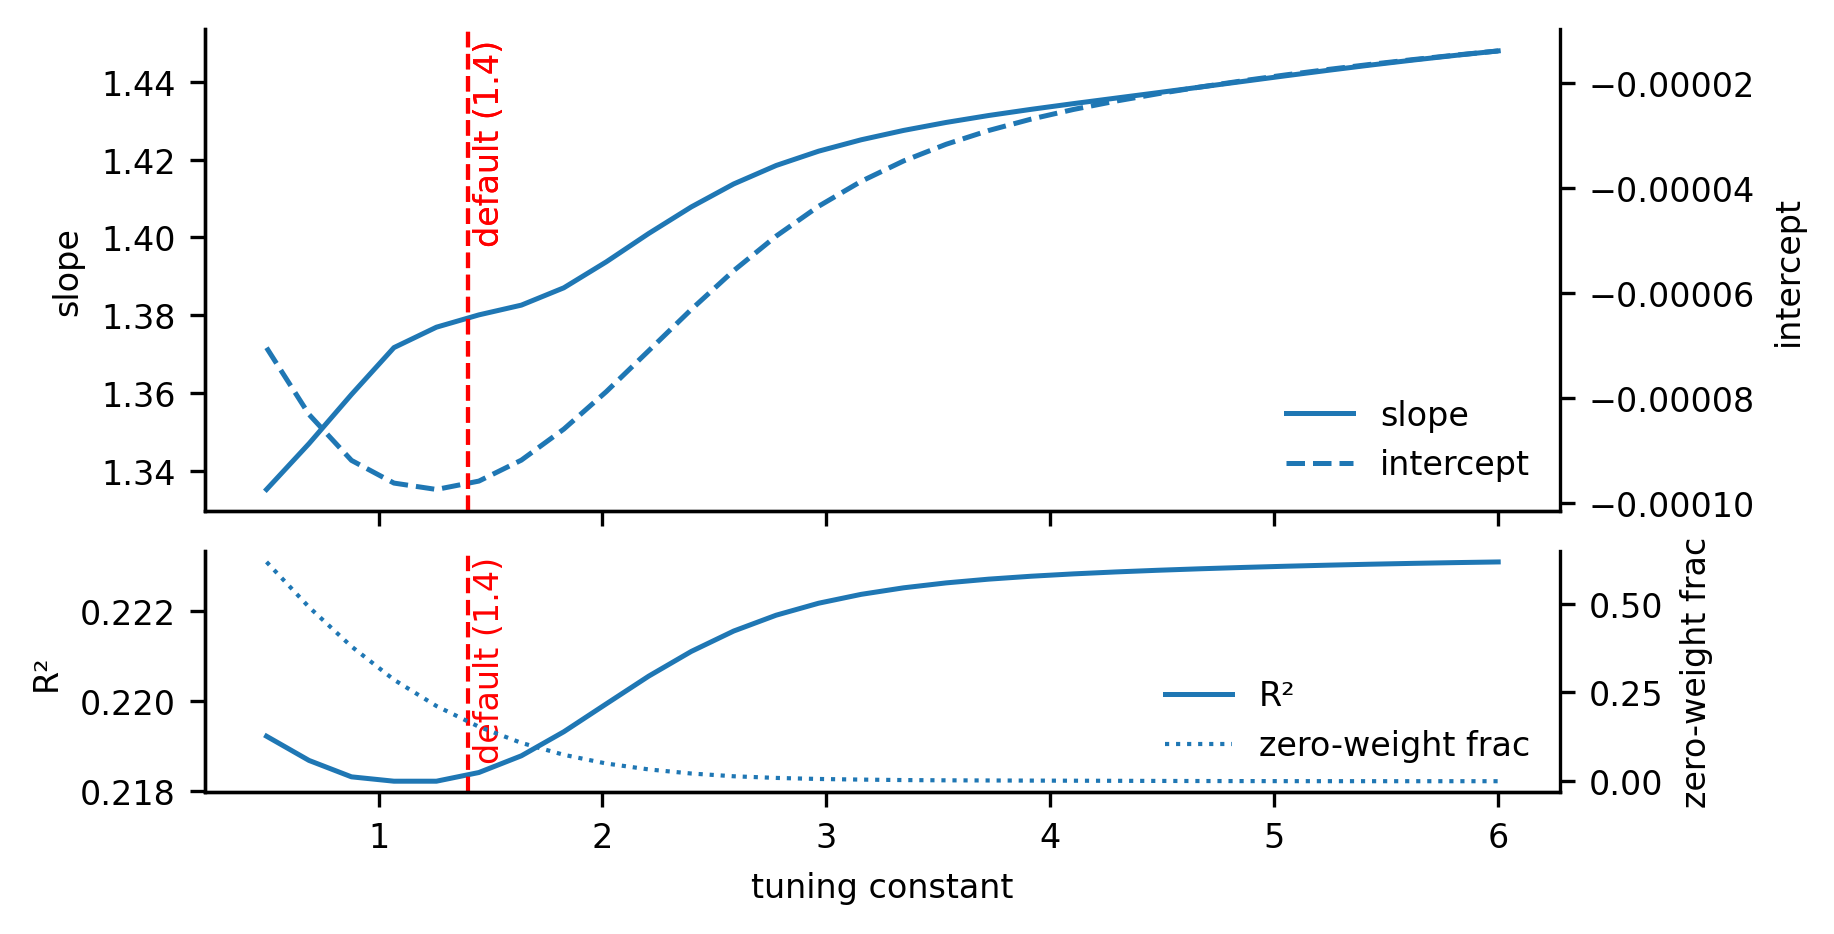

In [12]:
fig, (ax_top, ax_bot, ax_top_r, ax_bot_r) = plot_irls_tuning_sweep(df)

x0 = 1.4
for ax in (ax_top, ax_top_r, ax_bot):
    ax.axvline(x0, color="red", linestyle="--", linewidth=1)
    ax.text(
        x0 + 0.02,
        0.98,
        "default (1.4)",
        transform=ax.get_xaxis_transform(),
        color="red",
        fontsize=8,
        rotation=90,
        va="top",
        ha="left",
        clip_on=False,
    )

plt.show()

## 11) summary table (fit parameters and fit quality)

This table gathers the most relevant regression outputs for quick comparison.


In [13]:
rows = []
rows.append(
    {
        "method": "ols",
        "intercept": fit_ols_res["intercept"],
        "slope": fit_ols_res["slope"],
        "r2": fit_ols_res["r2"],
        "n_iter": fit_ols_res.get("n_iter"),
        "scale": fit_ols_res.get("scale"),
        "tuning_constant": None,
    }
)
rows.append(
    {
        "method": "irls_tukey",
        "intercept": fit_irls_res["intercept"],
        "slope": fit_irls_res["slope"],
        "r2": fit_irls_res["r2"],
        "n_iter": fit_irls_res.get("n_iter"),
        "scale": fit_irls_res.get("scale"),
        "tuning_constant": fit_irls_res.get("tuning_constant"),
    }
)
rows.append(
    {
        "method": "irls_huber",
        "intercept": fit_huber["intercept"],
        "slope": fit_huber["slope"],
        "r2": fit_huber["r2"],
        "n_iter": fit_huber.get("n_iter"),
        "scale": fit_huber.get("scale"),
        "tuning_constant": fit_huber.get("tuning_constant"),
    }
)

pd.DataFrame(rows)

,method,intercept,slope,r2,n_iter,scale,tuning_constant
0,ols,4.406853e-13,1.468215,0.223205,NaN,NaN,NaN
1,irls_tukey,-9.647398e-05,1.379395,0.218350,78.0,0.001300,1.4
2,irls_huber,-1.762954e-05,1.447647,0.223026,11.0,0.001301,1.4
